# Chapter 04 - Cell Ranger Filtered UMAP

## Objective

In this chapter, we load all single-nucleus RNA-seq datasets required for benchmarking the **Singulator + FACS** and **Singulator + LeviCell** protocols. We also verify metadata consistency, perform basic integrity checks, and prepare the data objects for downstream analysis.

This includes:

- Locating the data on the shared filesystem (Iris)
- Loading raw count matrices (e.g., `filtered_feature_bc_matrix.h5` from 10X)
- Loading data into `AnnData` objects

## Data Source

The data for this benchmarking project is stored on the **Iris** HPC filesystem under:

`/data1/collab002/sail/isabl/datalake/prod/010/collaborators/SAIL/projects/singulator_debris_removal_and/experiments`

We will be working with the data under identifier `MB-4027_*`


In [1]:
%load_ext autoreload
%autoreload 2

## Core Imports

In [2]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Dict, List, Union
import utils

## File Paths and Metadata

In [ ]:
# Constants
DATA_DIR = "./data"
READ_ONLY_DIR = os.path.join(DATA_DIR, "read_only")
FIGURES_OUTPUT_DIR = os.path.join(
    DATA_DIR, "figures", "chapter_06_cellbender_basic_analysis"
)
RAW_FEATURE_BC_MATRIX_FILE_NAME = "raw_feature_bc_matrix.h5"

GENE_SETS_DIR = os.path.join(DATA_DIR, "gene_sets_and_info")

# Make sure figures output directory exists
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

ANALYSIS_DIR = os.path.join(DATA_DIR, "analysis")
INPUT_ADATA_DIR = os.path.join(
    DATA_DIR, "adatas", "adatas_X_cellbender_raw_filtered_with_gene_metrics"
)
OUTPUT_ADATA_NO_CLUSTER_REMOVAL_DIR = os.path.join(
    DATA_DIR, "adatas", "adatas_X_cellbender_processed_filtered"
)
OUTPUT_ADATA_DIR = os.path.join(
    DATA_DIR, "adatas", "combined_adatas_cellbender_processed_filtered_clusters_removed"
)

# Make sure output adata dir directory exists
os.makedirs(OUTPUT_ADATA_DIR, exist_ok=True)

# Sample metadata - in data/metadata.tsv
samples = {
    "SF_N": ("MB-4027_SF_N", "Normal Colon", "Singulator+FACS"),
    "SL_N": ("MB-4027_SL_N", "Normal Colon", "Singulator+LeviCell"),
    "SF_T": ("MB-4027_SF_T", "Tumor Colon", "Singulator+FACS"),
    "SL_T": ("MB-4027_SL_T", "Tumor Colon", "Singulator+LeviCell"),
    "SF_LN": ("MB-4027_SF_LN", "Normal Liver", "Singulator+FACS"),
    "SL_LN": ("MB-4027_SL_LN", "Normal Liver", "Singulator+LeviCell"),
}

# Color palette for plotting
protocol_color_palette = {
    "Singulator+FACS": "#AEC6CF",
    "Singulator+LeviCell": "#FFDAB9",
}

## Read in AnnDatas

### Individual AnnDatas

In [4]:
# Load AnnData objects
adatas = {}
adata_metadata = {}
adata_tissues = []

for key, (folder, tissue, protocol) in samples.items():
    file_path = os.path.join(INPUT_ADATA_DIR, f"{key}_adata.h5ad")
    adata = sc.read_h5ad(file_path)
    adatas[key] = adata
    adata_metadata[key] = (tissue, protocol)
    adata_tissues.append(tissue)
    print(f"{key}: {adata}")

SF_N: AnnData object with n_obs × n_vars = 4483 × 38606
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    uns: 'barcode_indices_for_latents', 'barcodes_analyzed', 'barcodes_analyzed_inds', 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'estimator', 'features_analyzed_inds', 

## Doublet Detection

In [5]:
def run_scrublet(adata: sc.AnnData) -> None:
    """
    Run Scrublet doublet detection on the given AnnData object.

    Parameters:
    adata (sc.AnnData): The AnnData object to analyze.
    """
    sc.pp.scrublet(
        adata,
        sim_doublet_ratio=2.0,
        expected_doublet_rate=0.06,
        knn_dist_metric="euclidean",
        log_transform=True,
        n_prin_comps=30,
        random_state=0,
    )  # From Roshan's workshop


for key, adata in adatas.items():
    print(f"Running Scrublet on {key}...")
    run_scrublet(adata)

Running Scrublet on SF_N...


adata.X seems to be already log-transformed.


Running Scrublet on SL_N...


adata.X seems to be already log-transformed.


Running Scrublet on SF_T...


adata.X seems to be already log-transformed.


Running Scrublet on SL_T...


adata.X seems to be already log-transformed.


Running Scrublet on SF_LN...


adata.X seems to be already log-transformed.


Running Scrublet on SL_LN...


adata.X seems to be already log-transformed.


### Preprocessing and Graph Computation

In [6]:
# # Use downsampled reads for analysis
for key, adata in adatas.items():
    adata.layers["cellbender_raw"] = adata.X.copy()
    sc.pp.normalize_total(
        adata, target_sum=None, inplace=True
    )  # From both Roshan and sc-best-practices
    sc.pp.log1p(adata)

# Combine adatas by tissue
combined_by_tissue = {}
for tissue in adata_tissues:
    tissue_adatas = []
    for key, (tissue_name, protocol) in adata_metadata.items():
        if tissue_name == tissue:
            adata = adatas[key].copy()
            adata.obs["protocol"] = protocol
            adata.obs["tissue"] = tissue
            adata.obs["sample"] = key
            tissue_adatas.append(adata)

    combined = sc.concat(
        tissue_adatas,
        label="sample",
        keys=[a.obs["sample"].iloc[0] for a in tissue_adatas],
    )

    # Make obs and var names unique
    combined.obs_names_make_unique()
    combined.var_names_make_unique()

    # Filter cells and genes
    sc.pp.filter_cells(
        combined, min_genes=20
    )  # From (https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)
    sc.pp.filter_genes(combined, min_cells=np.exp(4))  # From Roshan's workshop

    # Compute graphs
    sc.pp.highly_variable_genes(
        combined,
        flavor="seurat_v3",
        n_top_genes=4000,
        batch_key="protocol",
        layer="cellbender_raw",
    )  # Using batch_key to account for protocol differences - want to keep genes that are variable across both protocols
    sc.pp.pca(
        combined, n_comps=None, mask_var="highly_variable", random_state=0
    )  #  Roshan's workshop calculated 100 comps, then moved forward with 30, but this took long - if set to None, "Defaults to 50, or (1 - minimum dimension size of selected representation)"
    sc.pp.neighbors(
        combined, n_neighbors=30, use_rep="X_pca", metric="euclidean", random_state=0
    )  # From Roshan's workshop

    # Compute UMAP and clustering
    sc.tl.umap(combined, min_dist=0.1, random_state=0)  # From Roshan's workshop
    sc.tl.leiden(
        combined, resolution=1, random_state=0, flavor="igraph", n_iterations=2
    )  # From Roshan's workshop - scanpy recommends flavor = "igraph" and n_iterations = 2

    combined_by_tissue[tissue] = combined

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.w

KeyboardInterrupt: 

### Save AnnDatas to File

In [ ]:
# Save AnnData to file:
for tissue, adata in combined_by_tissue.items():
    output_file = os.path.join(
        OUTPUT_ADATA_NO_CLUSTER_REMOVAL_DIR,
        f"{tissue.replace(' ', '_')}_combined_adata.h5ad",
    )
    adata.write(output_file)
    print(f"Saved {tissue} combined AnnData to {output_file}")

Saved Normal Colon combined AnnData to ./data/adatas/adatas_X_cellbender_processed_filtered/Normal_Colon_combined_adata.h5ad
Saved Tumor Colon combined AnnData to ./data/adatas/adatas_X_cellbender_processed_filtered/Tumor_Colon_combined_adata.h5ad
Saved Normal Liver combined AnnData to ./data/adatas/adatas_X_cellbender_processed_filtered/Normal_Liver_combined_adata.h5ad


In [11]:
combined_by_tissue = {}

# Save AnnData to file:
for tissue in adata_tissues:
    input_file = os.path.join(
        OUTPUT_ADATA_NO_CLUSTER_REMOVAL_DIR,
        f"{tissue.replace(' ', '_')}_combined_adata.h5ad",
    )
    adata = sc.read_h5ad(input_file)
    combined_by_tissue[tissue] = adata
    print(f"Read {tissue} combined AnnData from {input_file}")

Read Normal Colon combined AnnData from ./data/adatas/adatas_X_cellbender_processed_filtered/Normal_Colon_combined_adata.h5ad
Read Normal Colon combined AnnData from ./data/adatas/adatas_X_cellbender_processed_filtered/Normal_Colon_combined_adata.h5ad
Read Tumor Colon combined AnnData from ./data/adatas/adatas_X_cellbender_processed_filtered/Tumor_Colon_combined_adata.h5ad
Read Tumor Colon combined AnnData from ./data/adatas/adatas_X_cellbender_processed_filtered/Tumor_Colon_combined_adata.h5ad
Read Normal Liver combined AnnData from ./data/adatas/adatas_X_cellbender_processed_filtered/Normal_Liver_combined_adata.h5ad
Read Normal Liver combined AnnData from ./data/adatas/adatas_X_cellbender_processed_filtered/Normal_Liver_combined_adata.h5ad


### UMAP Plots

### Plot by Protocol

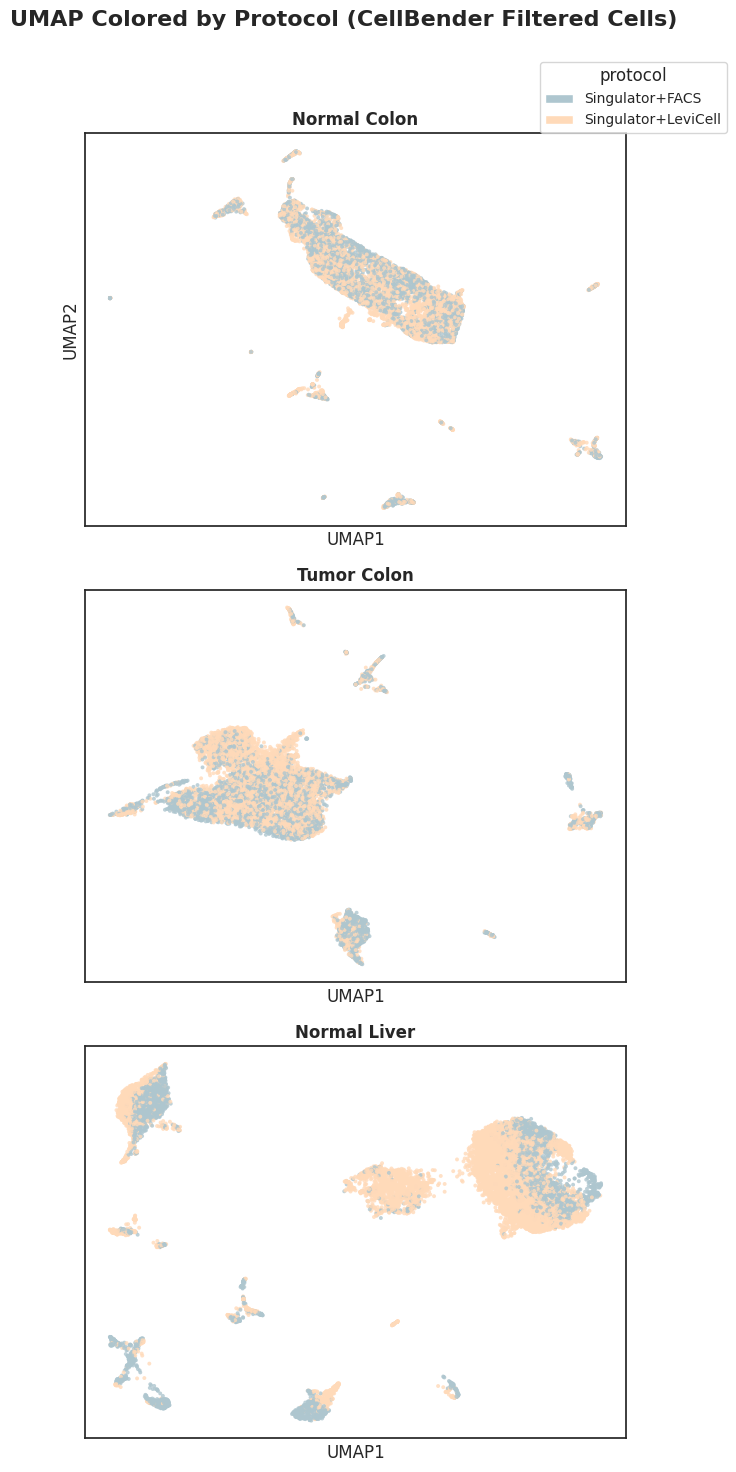

In [ ]:
# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="protocol",
    color_palette=protocol_color_palette,
    title="UMAP Colored by Protocol (CellBender Filtered Cells)",
    vertical = True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_protocol.png"), bbox_inches="tight"
)

### Plot by Library Size

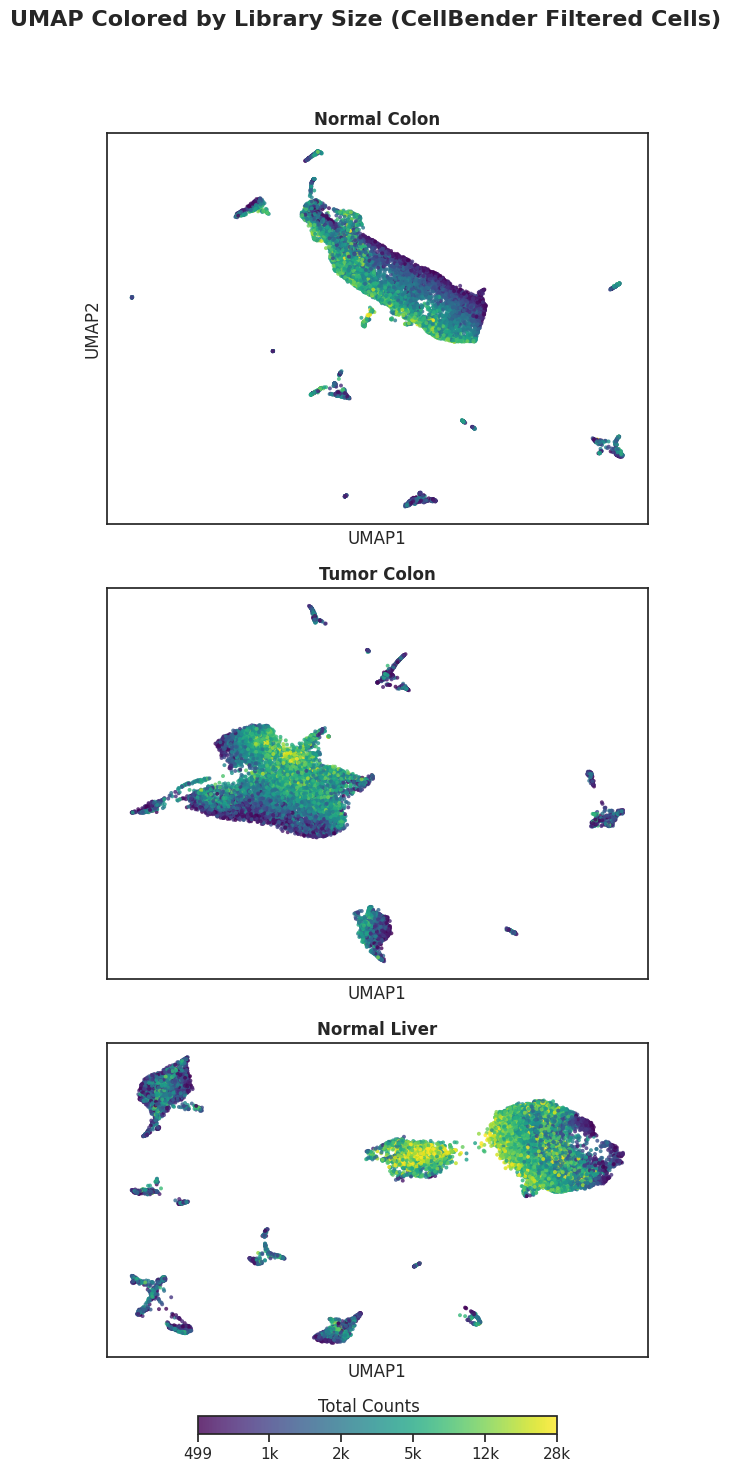

In [ ]:
# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="total_counts",
    color_palette="viridis",
    log_scale=True,
    clip_values=(0.0005, 0.99),
    title="UMAP Colored by Library Size (CellBender Filtered Cells)",
    vertical = True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_library_size.png"), bbox_inches="tight"
)

### Plot by Leiden Cluster

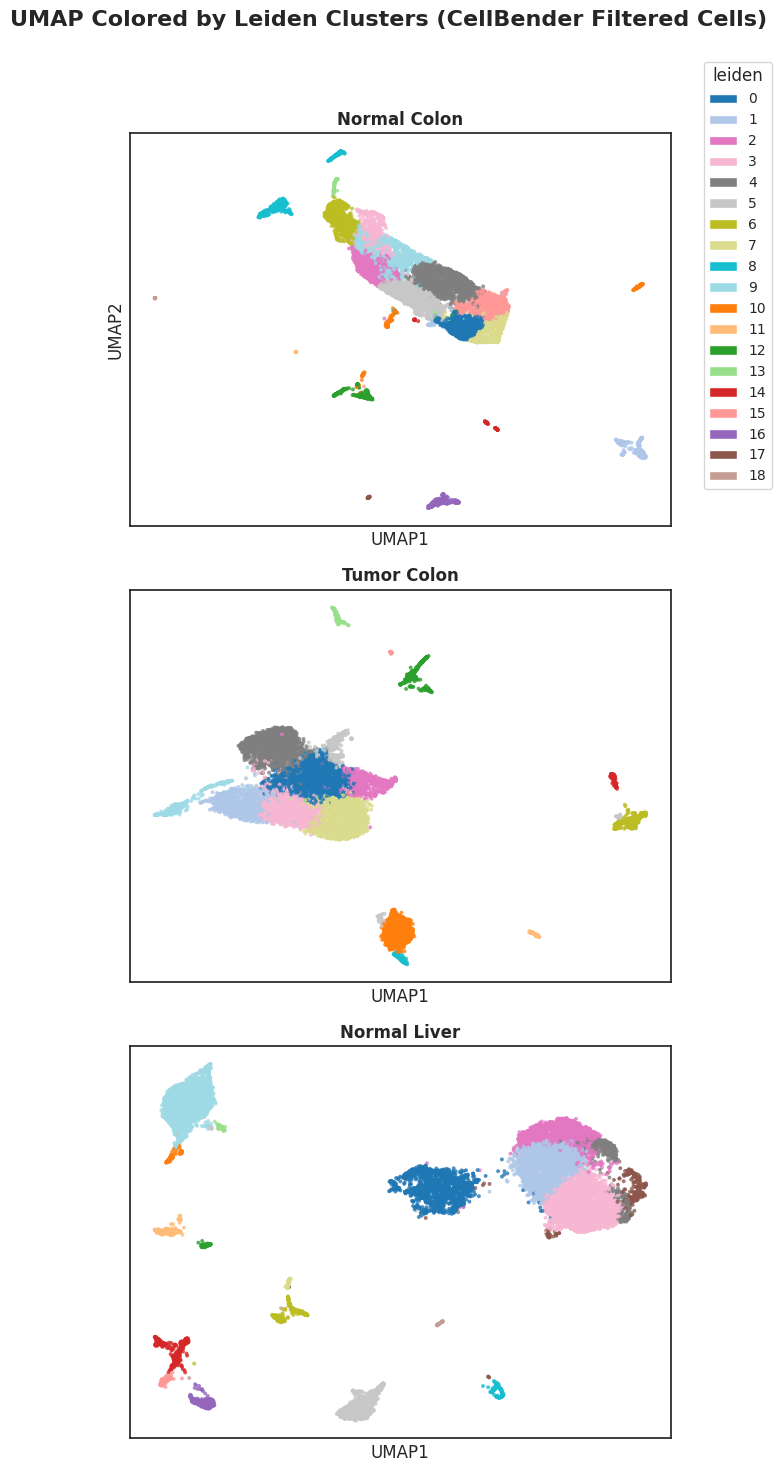

In [ ]:
# Plot UMAP colored by leiden cluster
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="leiden",
    color_palette="tab20",
    title="UMAP Colored by Leiden Clusters (CellBender Filtered Cells)",
    vertical=True,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "umap_by_leiden.png"), bbox_inches="tight")

### Cluster by Protocol Stackplots

/data1/collab002/sail/projects/ongoing/benchmarks/sail-benchmarking-template/utils/plotting_utils/barplots_and_boxplots_plotting_utils.py:436: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivoted = counts.pivot_table(


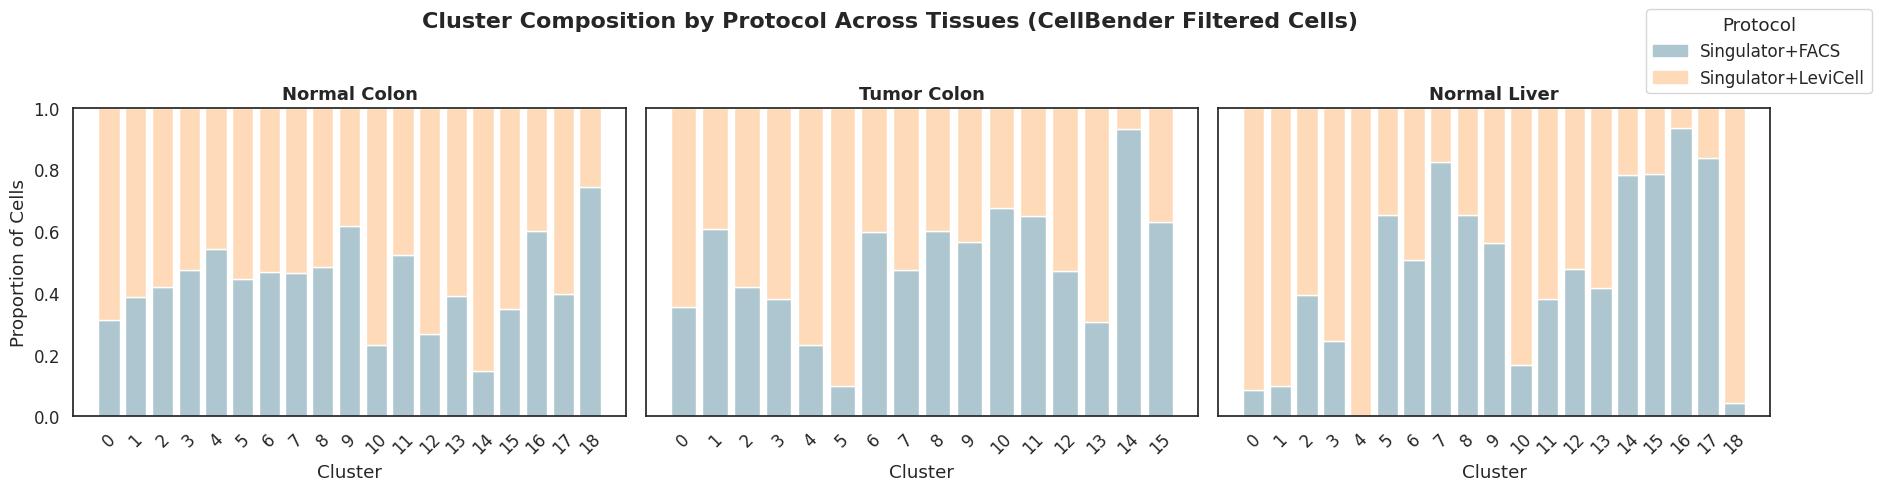

In [ ]:
fig = utils.plot_cluster_protocol_stackplots(
    combined_by_tissue=combined_by_tissue,
    cluster_key="leiden",
    protocol_key="protocol",
    protocol_color_palette=protocol_color_palette,
    tissue_order=set(adata_tissues),
    title="Cluster Composition by Protocol Across Tissues (CellBender Filtered Cells)",
)

fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "cluster_stackplot_cellranger_filtered.png"),
    bbox_inches="tight",
)

## Doublets

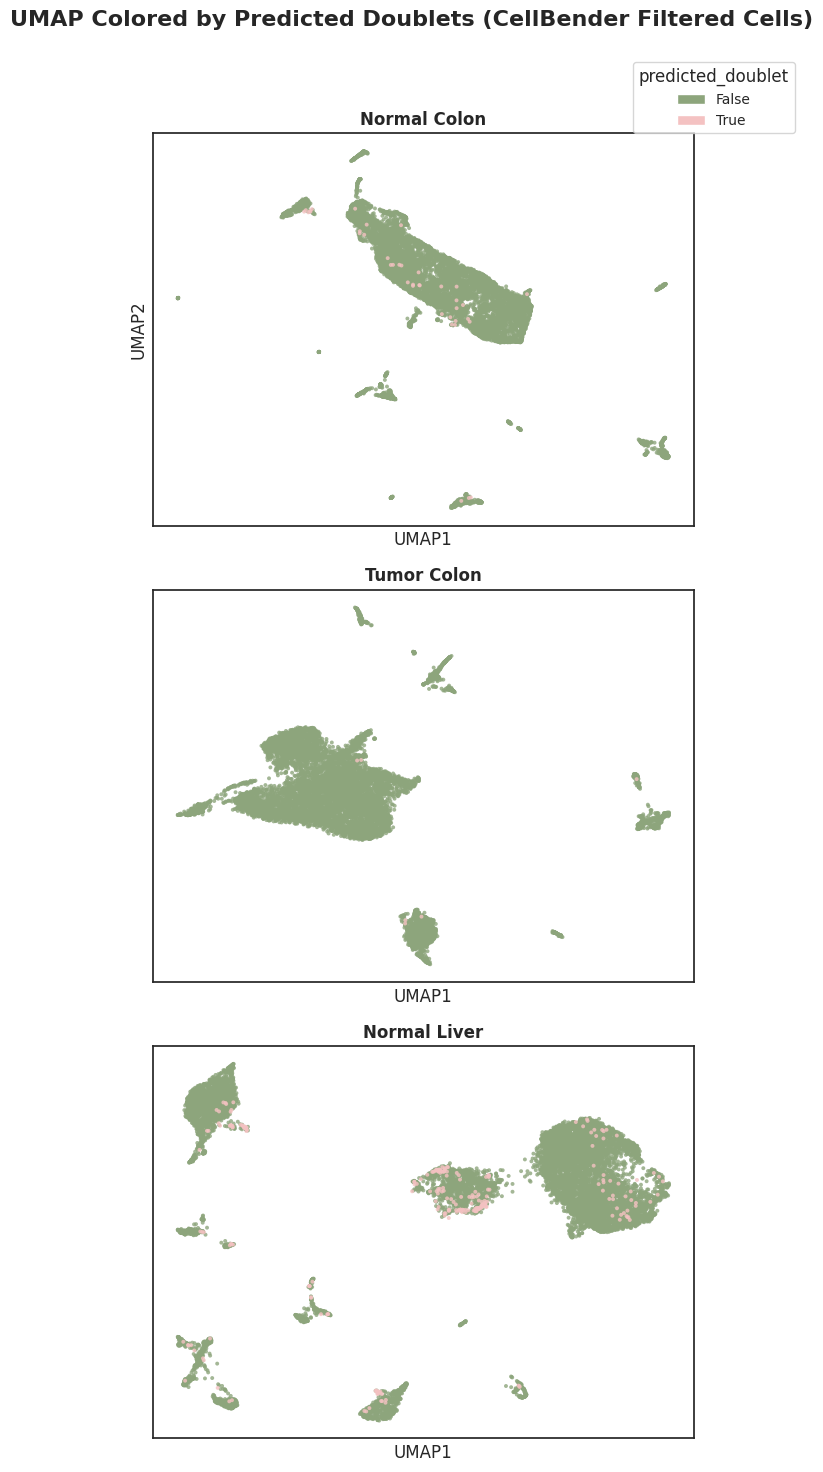

In [ ]:
doublet_palette = {
    False: "#8DA57C",  # pastel blue
    True: "#f4c2c2",  # pastel pink
}

fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="predicted_doublet",
    color_palette=doublet_palette,
    title="UMAP Colored by Predicted Doublets (CellBender Filtered Cells)",
    vertical=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_predicted_doublets.png"),
    bbox_inches="tight",
)

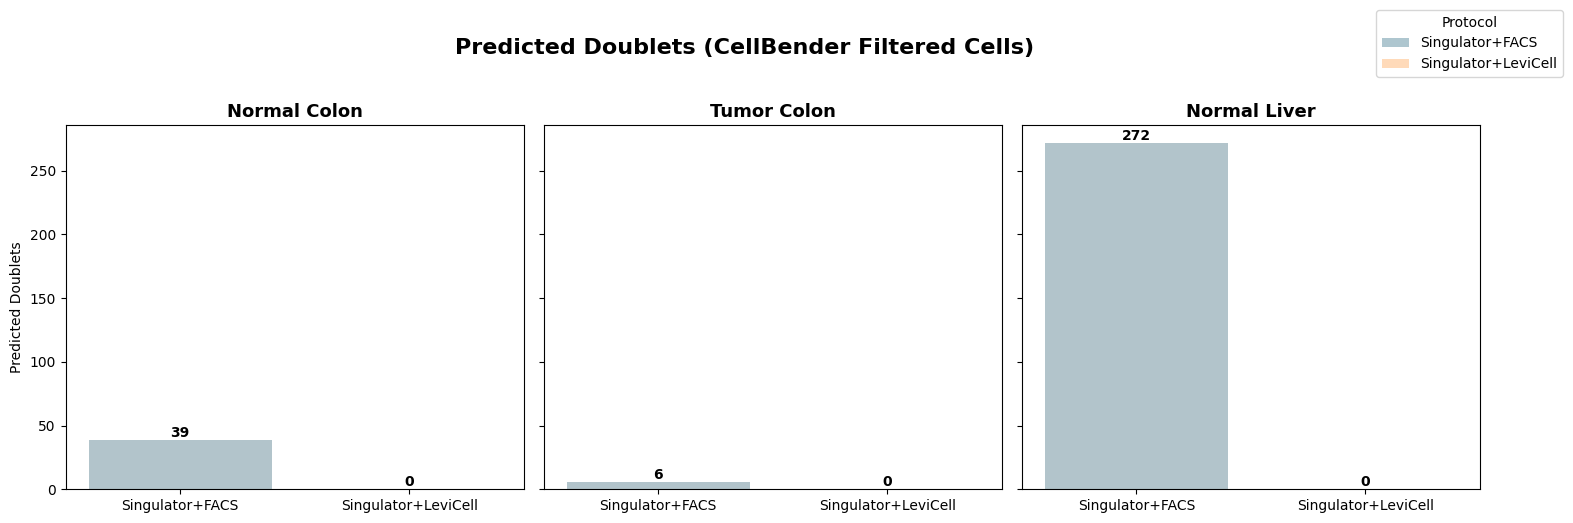

In [12]:
# Plot number of cells
fig = utils.plot_scalar_metric(
    data_dict=adatas,
    metadata=adata_metadata,
    metric_func=lambda adata: int(adata.obs["predicted_doublet"].sum()),
    metric_label="Predicted Doublets",
    protocol_color_palette=protocol_color_palette,
    title="Predicted Doublets (CellBender Filtered Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "predicted_doublets_by_protocol.png"),
    bbox_inches="tight",
)

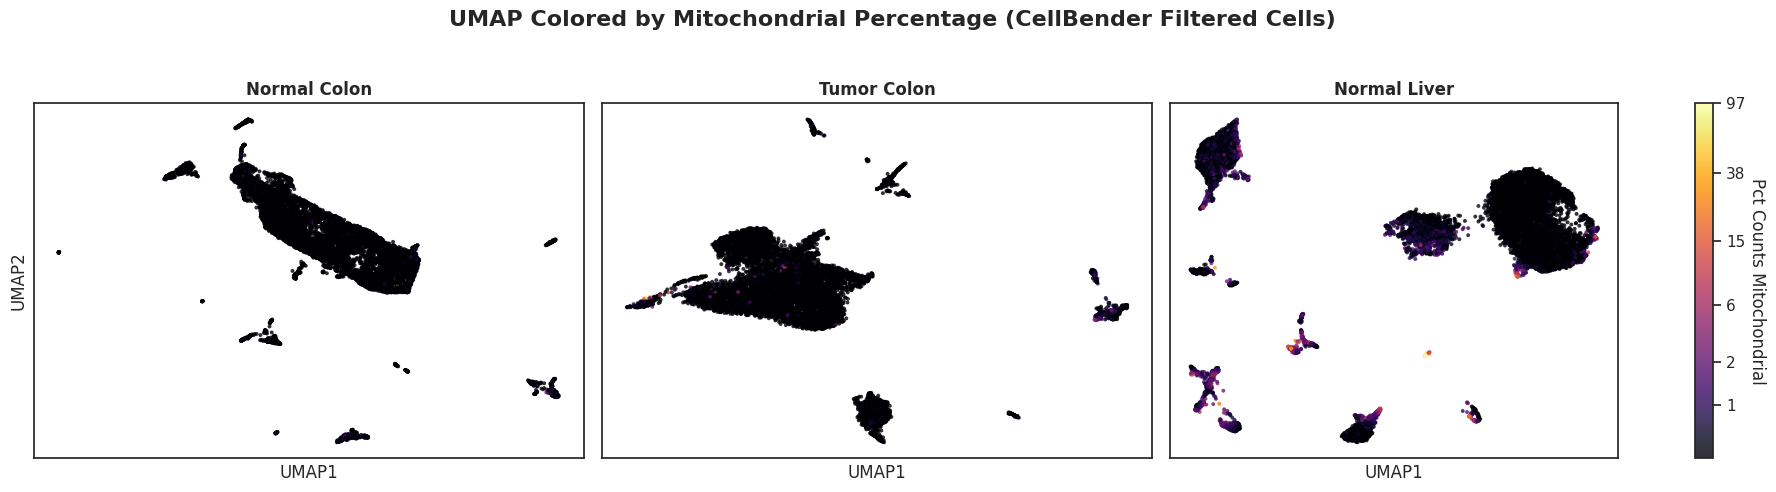

In [20]:
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="pct_counts_mitochondrial",
    color_palette="inferno",
    log_scale=True,
    title="UMAP Colored by Mitochondrial Percentage (CellBender Filtered Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_mitochondrial.png"),
    bbox_inches="tight",
)

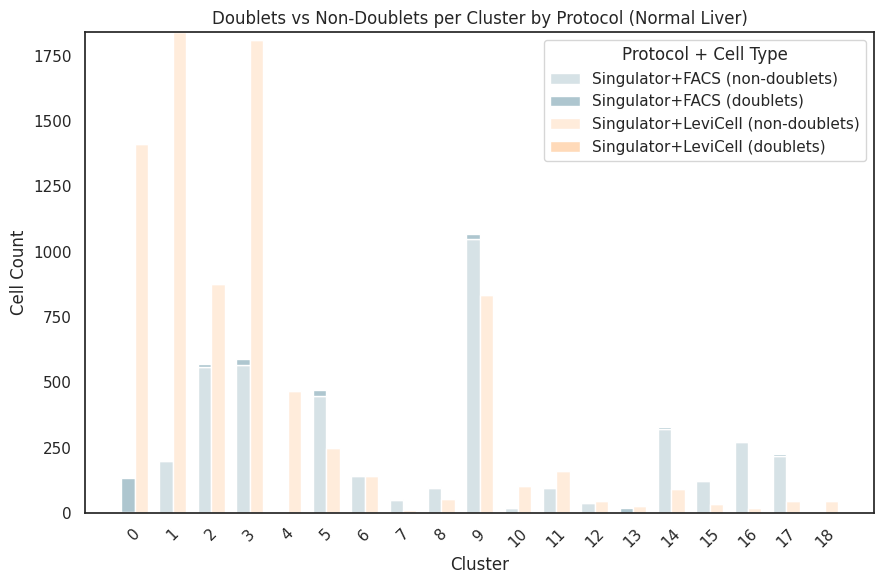

In [ ]:
fig = utils.plot_doublet_stack_by_cluster(
    combined_by_tissue=combined_by_tissue,
    tissue="Normal Liver",
    color_palette=protocol_color_palette,
)

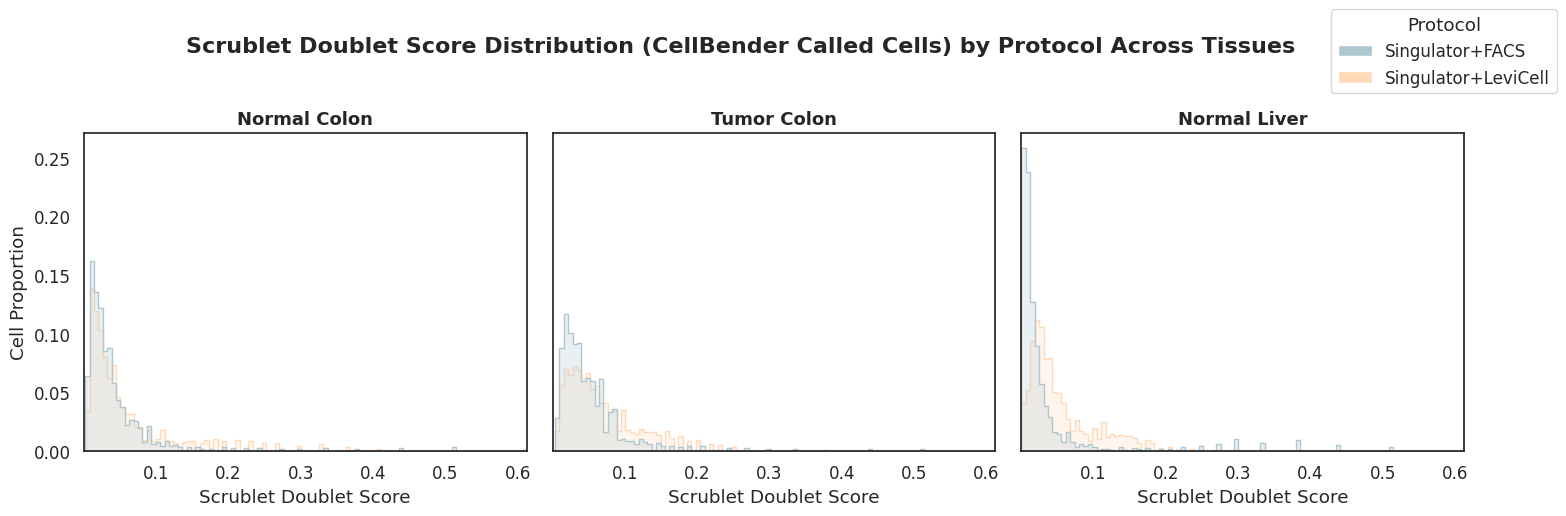

In [ ]:
# Plot doublet score distribution
fig = utils.plot_adata_metric_histogram(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="doublet_score",
    axis="obs",
    log_x=False,
    x_label="Scrublet Doublet Score",
    title="Scrublet Doublet Score Distribution (CellBender Called Cells) by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "scrublet_doublet_score_historgram.png"),
    bbox_inches="tight",
)

<string>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


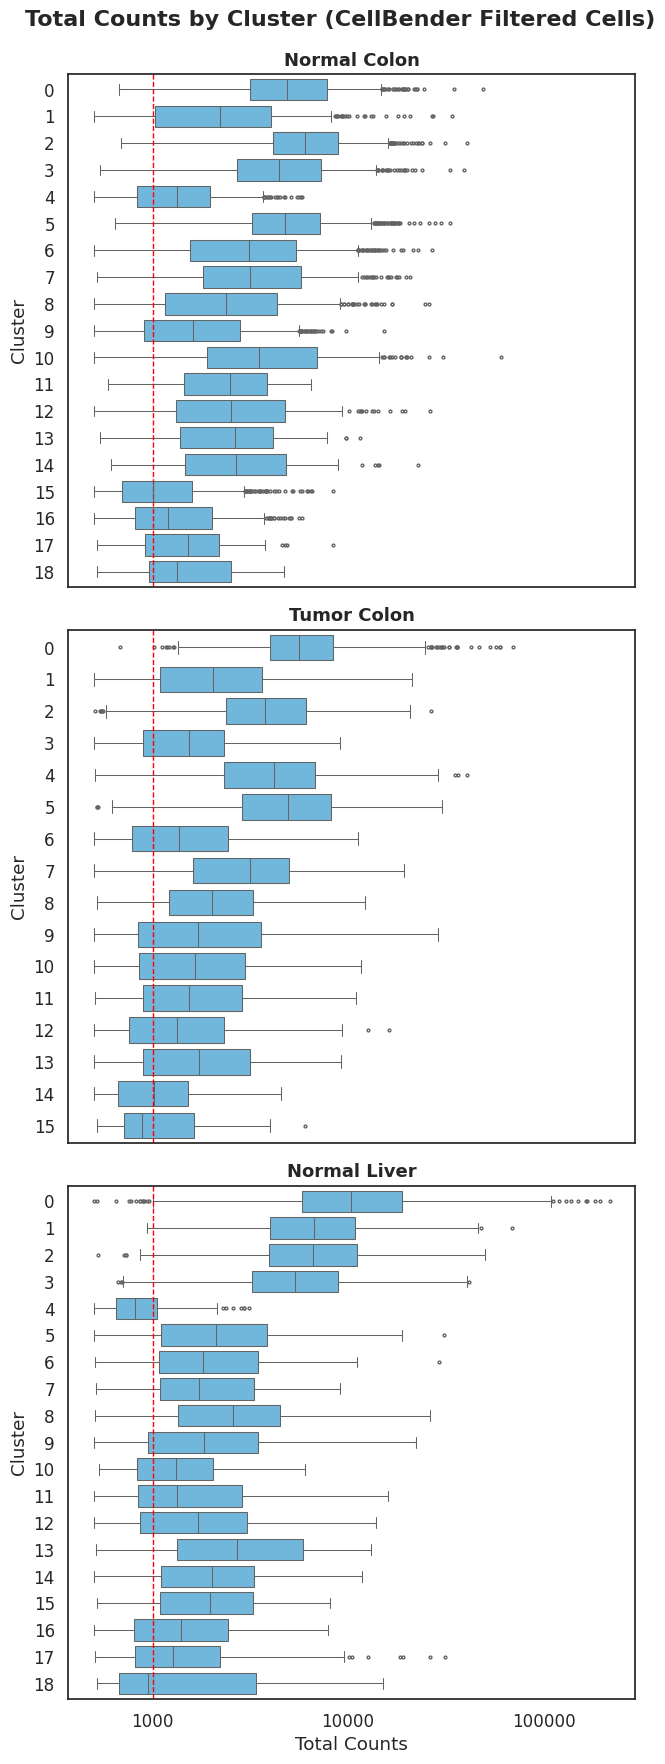

In [17]:
fig = utils.plot_cluster_metric_boxplots(
    combined_by_tissue,
    metric="total_counts",
    log_scale=True,
    axline=1000,
    vertical=True,
    title="Total Counts by Cluster (CellBender Filtered Cells)",
)

<string>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


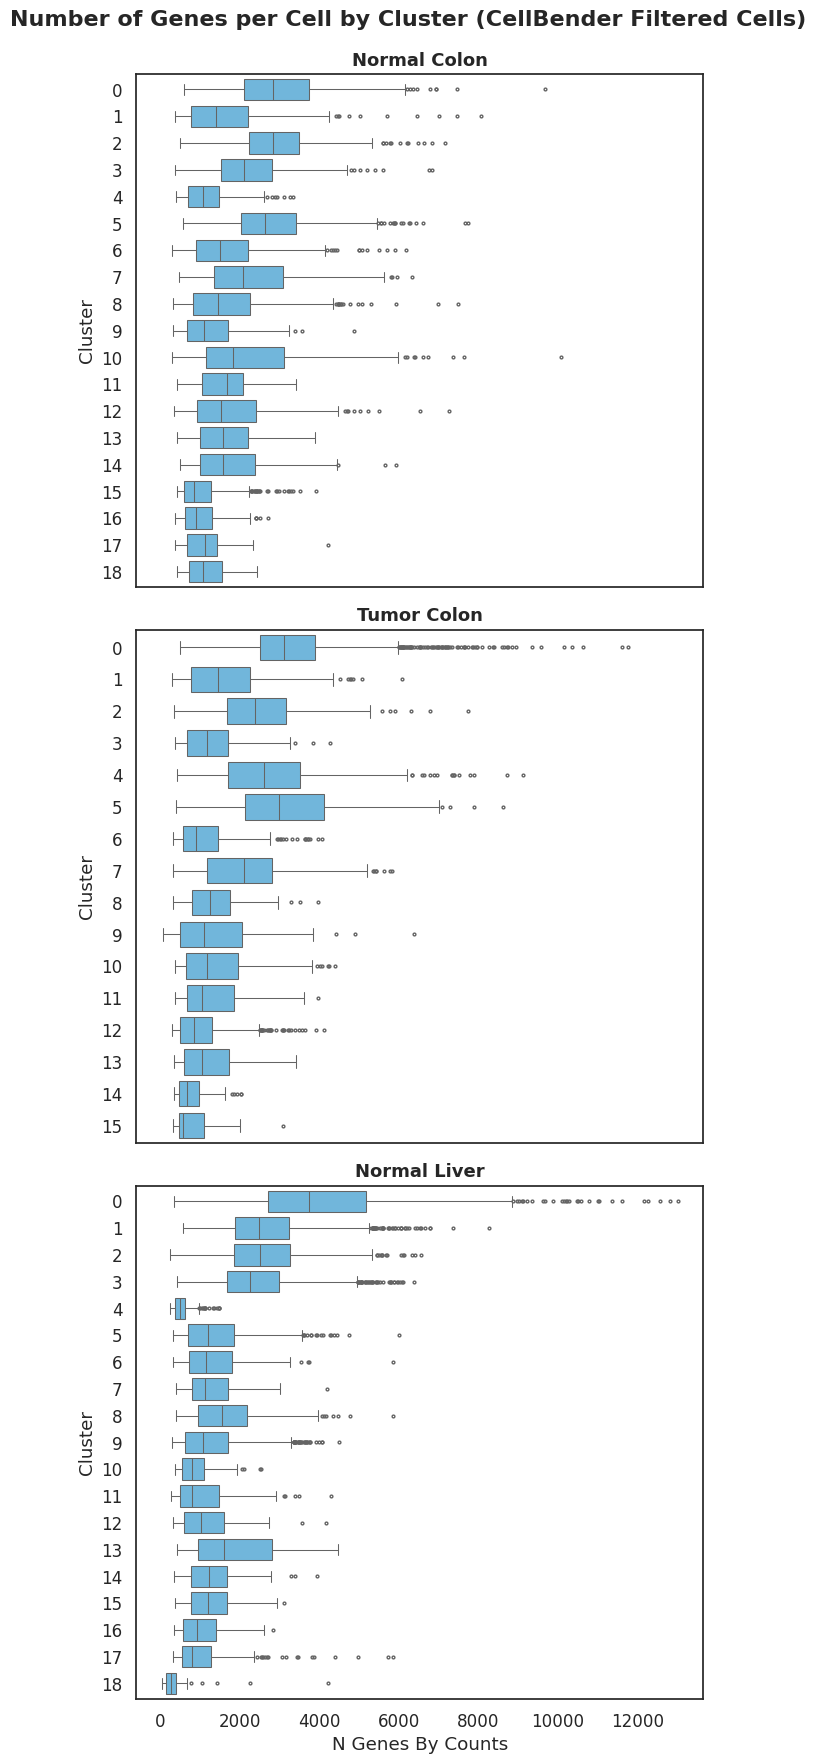

In [18]:
fig = utils.plot_cluster_metric_boxplots(
    combined_by_tissue,
    metric="n_genes_by_counts",
    log_scale=False,
    axline=None,
    vertical=True,
    title="Number of Genes per Cell by Cluster (CellBender Filtered Cells)",
)

<string>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


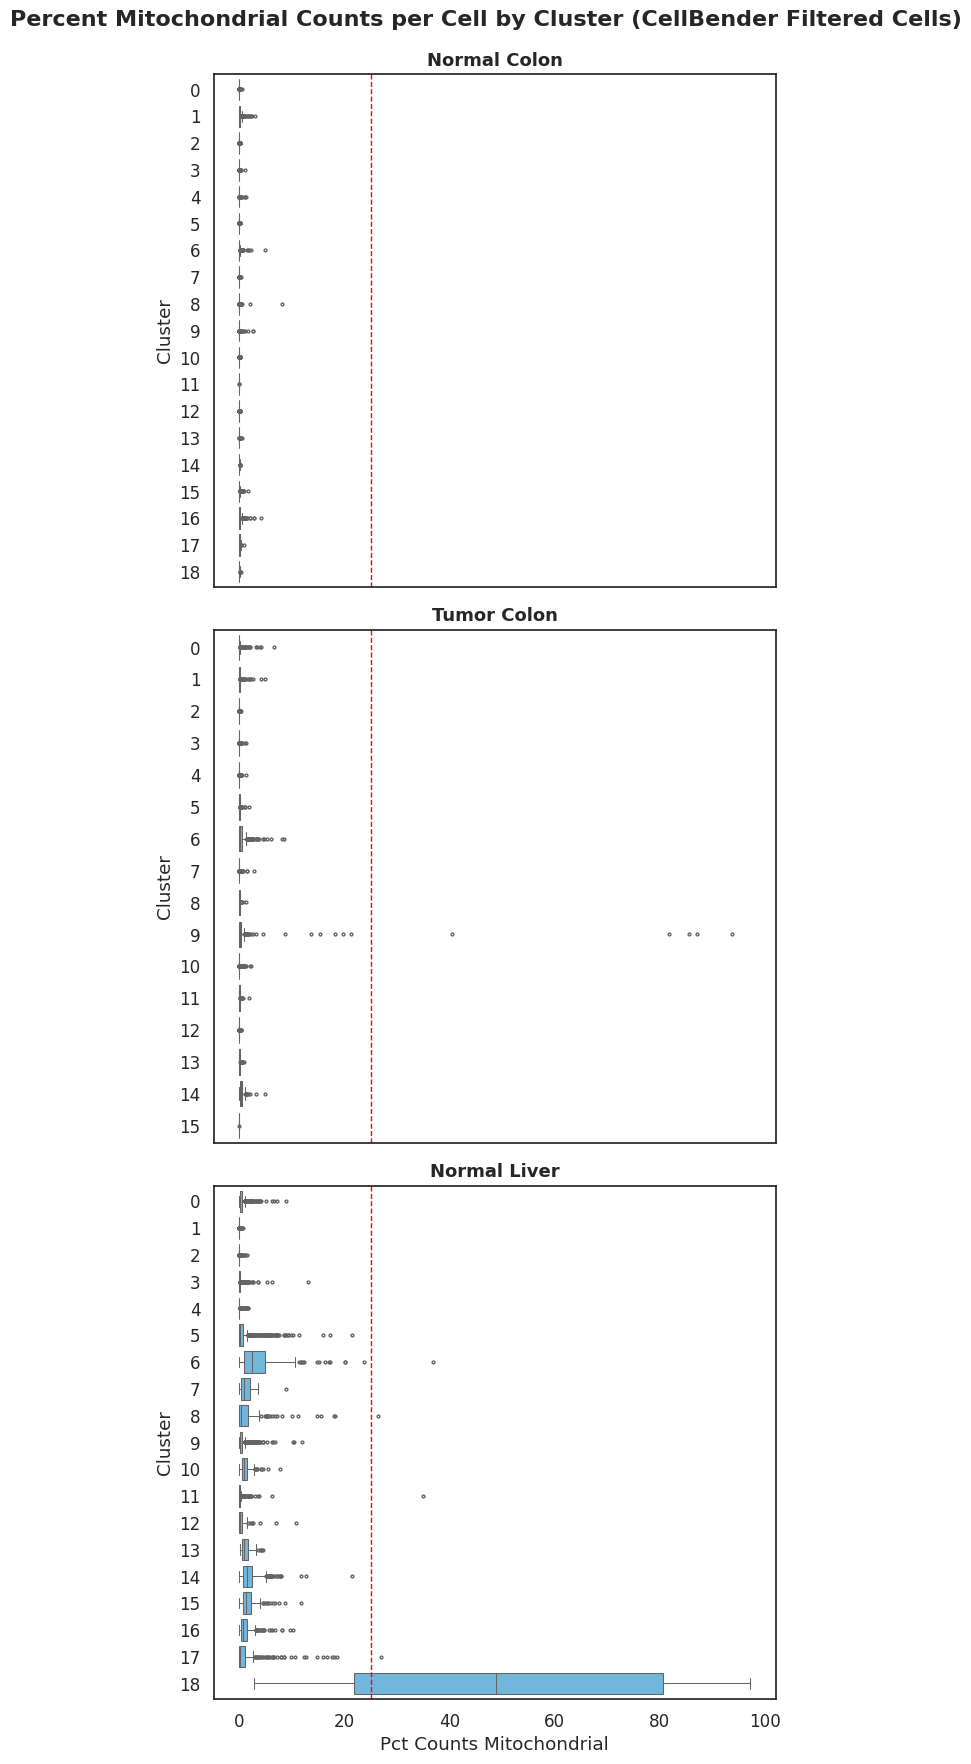

In [19]:
fig = utils.plot_cluster_metric_boxplots(
    combined_by_tissue,
    metric="pct_counts_mitochondrial",
    vertical=True,
    log_scale=False,
    axline=25,
    title="Percent Mitochondrial Counts per Cell by Cluster (CellBender Filtered Cells)",
)

In [21]:
fig = utils.plot_cluster_metric_boxplots(
    combined_by_tissue,
    metric="total_counts",
    log_scale=True,
    axline=1000,
    vertical=True,
    title="Total Counts by Cluster (CellBender Filtered Cells)",
    cluster_key = ""
)

KeyError: "[''] not in index"

In [22]:
# Normal Colon
normal_colon_combined_adata = combined_by_tissue["Normal Colon"].copy()
# print(f"Normal Colon Combined AnnData: {normal_colon_combined_adata}")
# normal_colon_combined_adata = normal_colon_combined_adata[
#     normal_colon_combined_adata.obs["leiden"] != "1"
# ].copy()
print(f"Normal Colon Combined AnnData after filtering: {normal_colon_combined_adata}")

# Tumor Colon
tumor_colon_combined_adata = combined_by_tissue["Tumor Colon"].copy()
print(f"Tumor Colon Combined AnnData: {tumor_colon_combined_adata}")
# tumor_colon_combined_adata = tumor_colon_combined_adata[
#     tumor_colon_combined_adata.obs["leiden"] != "0"
# ].copy()
print(f"Tumor Colon Combined AnnData after filtering: {tumor_colon_combined_adata}")

# Normal Liver
normal_liver_combined_adata = combined_by_tissue["Normal Liver"].copy()
print(f"Normal Liver Combined AnnData: {normal_liver_combined_adata}")
normal_liver_combined_adata = normal_liver_combined_adata[
    normal_liver_combined_adata.obs["leiden"] != "18"
].copy()
print(f"Normal Liver Combined AnnData after filtering: {normal_liver_combined_adata}")

Normal Colon Combined AnnData after filtering: AnnData object with n_obs × n_vars = 9988 × 17979
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'doublet_score', 'predicted_doublet', 'protocol', 'tissue', 'sample', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'cellbender_embedding'
    varm: 'PCs'
    layers: 'cellbender', 'cellbender_raw', 'raw'
    obsp: 'connectivities', 'distances'
Tumor Colon Combined AnnData: AnnData object wit

In [27]:
def process_combined_adata(combined: sc.AnnData) -> None:
    """
    Process the combined AnnData object by filtering cells and genes, computing graphs, and clustering.

    Parameters:
    combined (sc.AnnData): The combined AnnData object to process.
    """
    # Filter cells and genes
    sc.pp.filter_cells(
        combined, min_genes=20
    )  # From (https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)
    sc.pp.filter_genes(combined, min_cells=np.exp(4))  # From Roshan's workshop

    # Compute graphs
    sc.pp.highly_variable_genes(
        combined,
        flavor="seurat_v3",
        n_top_genes=4000,
        batch_key="protocol",
        layer="cellbender_raw",
    )  # Using batch_key to account for protocol differences - want to keep genes that are variable across both protocols
    sc.pp.pca(
        combined, n_comps=None, mask_var="highly_variable", random_state=0
    )  #  Roshan's workshop calculated 100 comps, then moved forward with 30, but this took long - if set to None, "Defaults to 50, or (1 - minimum dimension size of selected representation)"
    sc.pp.neighbors(
        combined, n_neighbors=30, use_rep="X_pca", metric="euclidean", random_state=0
    )  # From Roshan's workshop

    # Compute UMAP and clustering
    sc.tl.umap(combined, min_dist=0.1, random_state=0)  # From Roshan's workshop
    sc.tl.leiden(
        combined, resolution=1, random_state=0, flavor="igraph", n_iterations=2
    )  # From Roshan's workshop - scanpy recommends flavor = "igraph" and n_iterations = 2
    return


# Process each combined adata
# process_combined_adata(normal_colon_combined_adata)
# process_combined_adata(tumor_colon_combined_adata)
process_combined_adata(normal_liver_combined_adata)

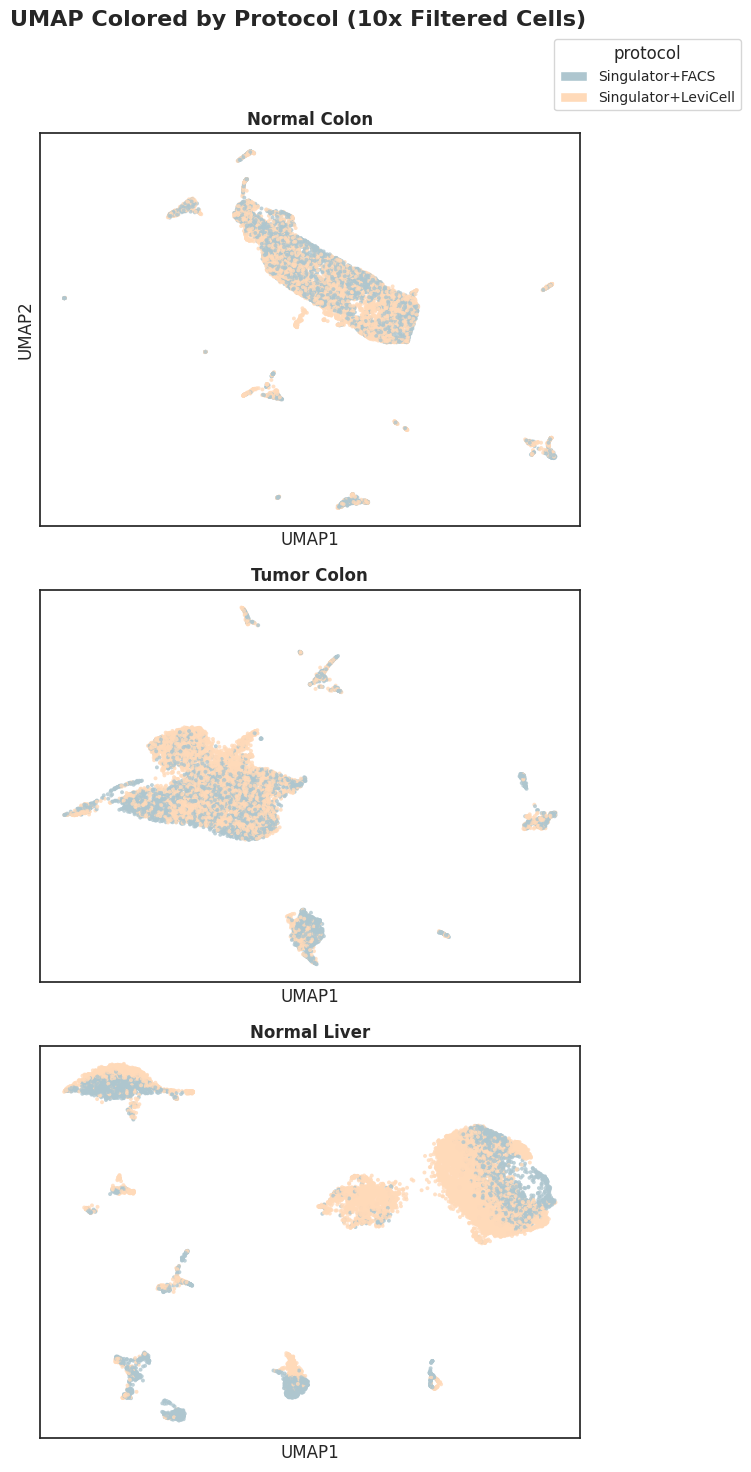

In [28]:
combined_by_tissue_clusters_removed = {}

combined_by_tissue_clusters_removed["Normal Colon"] = normal_colon_combined_adata
combined_by_tissue_clusters_removed["Tumor Colon"] = tumor_colon_combined_adata
combined_by_tissue_clusters_removed["Normal Liver"] = normal_liver_combined_adata

# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue_clusters_removed,
    feature="protocol",
    color_palette=protocol_color_palette,
    title="UMAP Colored by Protocol (10x Filtered Cells)",
    vertical=True,
    legend_bbox_to_anchor=(1.25, 0.965),
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_protocol_clusters_removed.png"),
    bbox_inches="tight",
)

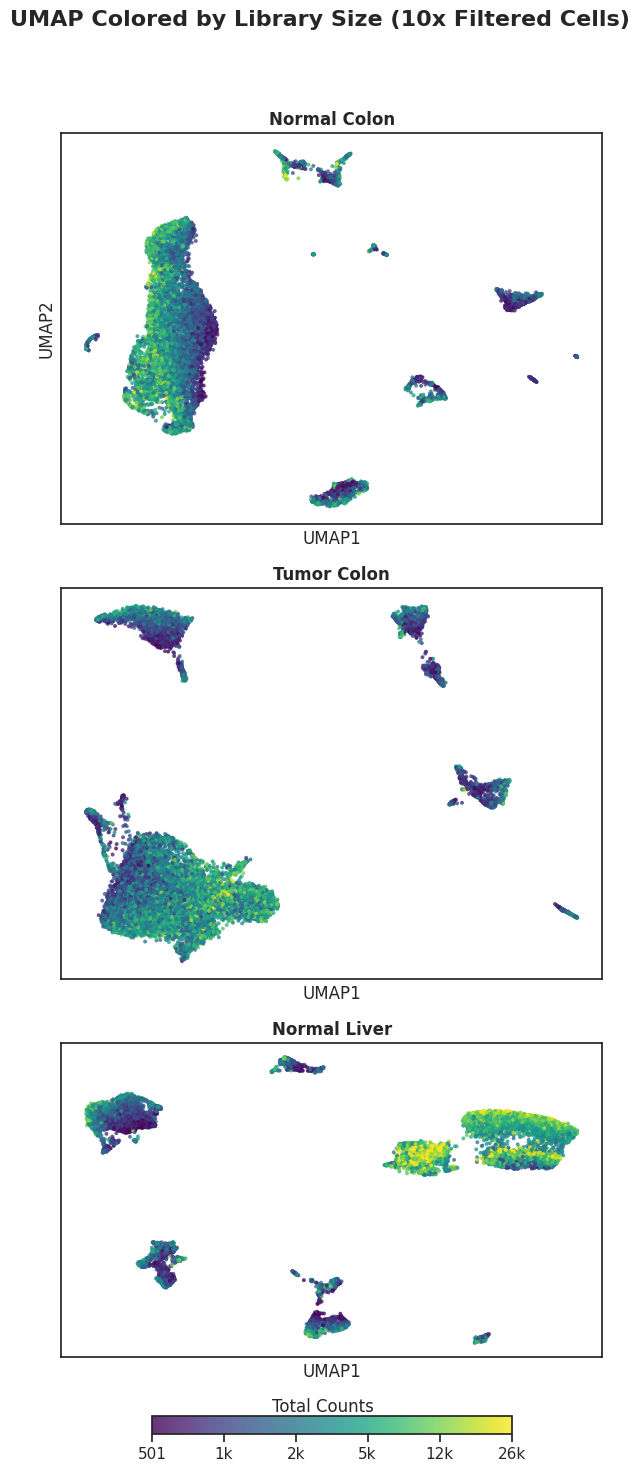

In [ ]:
# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue_clusters_removed,
    feature="total_counts",
    color_palette="viridis",
    log_scale=True,
    clip_values=(0.0005, 0.99),
    title="UMAP Colored by Library Size (10x Filtered Cells)",
    vertical=True,
    legend_bbox_to_anchor=(1.25, 0.965),
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_library_size_clusters_removed.png"),
    bbox_inches="tight",
)

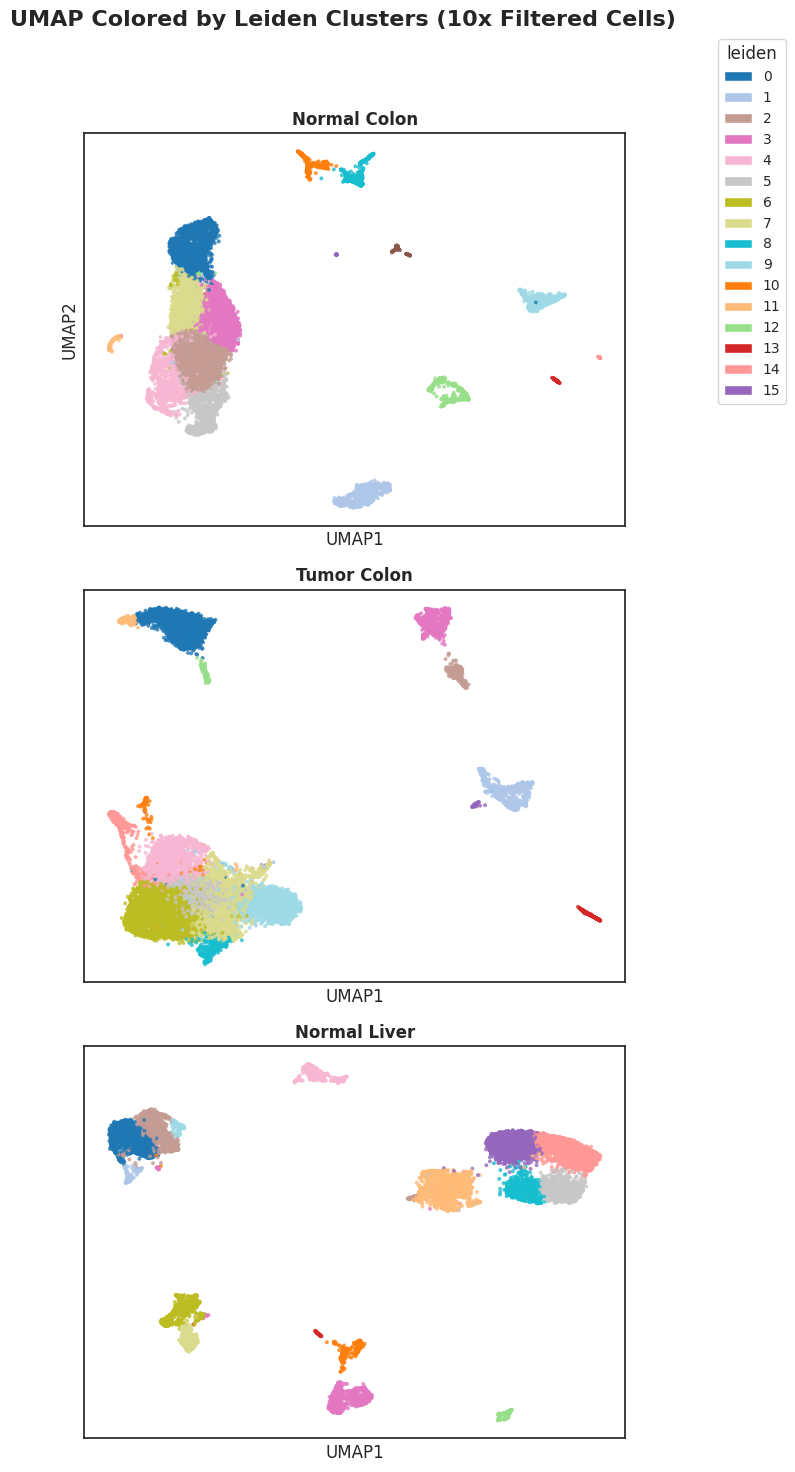

In [ ]:
# Plot UMAP colored by leiden cluster
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue_clusters_removed,
    feature="leiden",
    color_palette="tab20",
    title="UMAP Colored by Leiden Clusters (10x Filtered Cells)",
    vertical=True,
    legend_bbox_to_anchor=(1.25, 0.965),
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_leiden_clusters_removed.png"),
    bbox_inches="tight",
)

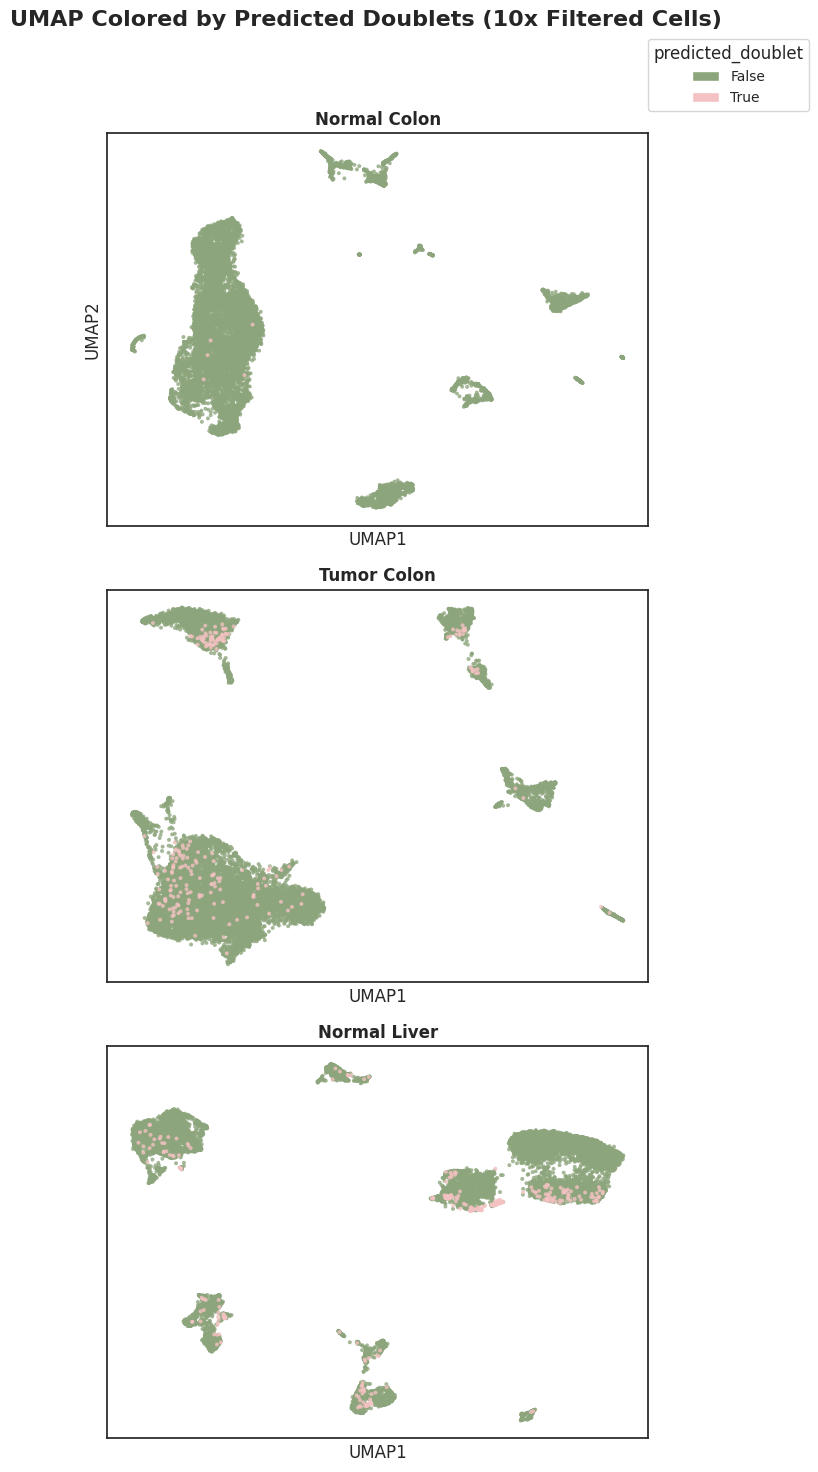

In [ ]:
doublet_palette = {
    False: "#8DA57C",  # pastel blue
    True: "#f4c2c2",  # pastel pink
}

fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue_clusters_removed,
    feature="predicted_doublet",
    color_palette=doublet_palette,
    title="UMAP Colored by Predicted Doublets (10x Filtered Cells)",
    vertical=True,
    legend_bbox_to_anchor=(1.25, 0.965),
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_predicted_doublets_clusters_removed.png"),
    bbox_inches="tight",
)

In [24]:
# Save AnnData to file:
for tissue, adata in combined_by_tissue_clusters_removed.items():
    output_file = os.path.join(
        OUTPUT_ADATA_DIR,
        f"{tissue.replace(' ', '_')}_combined_adata_clusters_removed.h5ad",
    )
    adata.write(output_file)
    print(f"Saved {tissue} combined AnnData to {output_file}")

NameError: name 'combined_by_tissue_clusters_removed' is not defined